# Exercises

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import scipy
import scipy.stats
import scipy.io
import matplotlib.pyplot as plt
from ipywidgets import interact
import ipywidgets as widgets
from tqdm import tqdm
import seaborn as sns
import pickle
import sys
import os
sys.path.append(os.path.abspath("/content/drive/MyDrive/Colab Notebooks/Neuro_Analysis/single-cell-analysis/01-tuning-curves/code"))
from utils import download_data

sns.set_theme(context='notebook',style='white',font_scale=1.5,
              rc = {'axes.spines.top':False,'axes.spines.right':False})

## Exercise 1 - simulating place cells
---
Use the code we build to simulate place cells in the lesson.

A - Explore what happens when you change the binning in the definition of the firing rate maps (`space_bins`). Make it coarser or broader.


B - In the spike train simulations, we add some "baseline" noise, not place-related to the firing. Which variable determines the noise level? Try to experiment with that variable and see what happens to the firing rate maps. What is the best approach to firing rate maps when the noise is high.


C - We could use other approaches to firing rate maps: for example make the binning very small (down to 1 cm, which is the resolution of our "video" data, and then applying a gaussian smoother. Scipy has a Gaussian smoother at `scipy.stats.gaussian_kde`. Read the documentation for that function and apply it to the data to define the smoothed firing rate maps. Again, change the noise levels and see how the smoother changes.

D - When analyzing place fields, two important quantities are the place field center and the place field width. The place field center may be defined in many ways, but one is to compute the "center of mass" of the spikes according to the equation

$$ c_{pf} = \frac{1}{N_{spikes}} \sum_{i} L_i $$

where the sum on $i$ runs on all spikes emitted by a cell and $L_i$ is the location at which the i-th spike was emitted. Calculate this for each cell. Compare with the "true" place field centers from the simulations (which variables are we talking about?)


In [3]:
def get_true_firing_rate(bins= np.arange(0., 200.), n_cells=100, average_firing_rate = 5):
  true_firing_rate_maps = np.zeros((n_cells, len(bins)))
  pf_centers = np.random.rand(n_cells) * track_length   # the centers of the place fields for all cells drawn randomly with a uniform distribution on the track
  pf_size = np.random.gamma(10, size=n_cells)   # the size (width) of the place fields, drawn randomly from a gamma distribution
  pf_rate = np.random.exponential(scale=average_firing_rate, size=n_cells)    # the peak firing rate for each cell, drawn from an exponential distribution

  for i in range(n_cells):
      true_firing_rate_maps[i,:] = pf_rate[i] * np.exp(-((bins-pf_centers[i])**2)/(2*pf_size[i]**2))
  return true_firing_rate_maps, pf_centers

In [4]:
def simulate_mouse_trajectory(bins, n_runs=20, av_running_speed=10, fps=30):
#n_runs = 20
#av_running_speed = 10 # the average running speed (in cm/s)
#fps = 30 # the number of "video frames" per second
  running_speed_a = np.random.chisquare(10, size=n_runs) # running speed in the two directions
  running_speed_b = np.random.chisquare(10, size=n_runs)

  stopping_time_a = np.random.chisquare(15, size=n_runs) # the time the mouse will spend at the two ends of the track
  stopping_time_b = np.random.chisquare(15, size=n_runs)

  x = np.array([])
  for i in range(n_runs):
      stop1 = np.ones((int(stopping_time_a[i]*fps),)) * 0.
      run_length = len(bins) * fps / running_speed_a[i]
      run1 = np.linspace(0., float(len(bins)-1), int(run_length))
      stop2 = np.ones((int(stopping_time_b[i]*fps),)) * (len(bins)-1.)
      run_length = len(bins) * fps / running_speed_b[i]
      run2 = np.linspace(len(bins)-1., 0., int(run_length))
      x = np.concatenate((x, stop1, run1, stop2, run2))
  t = np.arange(len(x))/fps

  return t, x

In [5]:
def simulate_spiking(t, x, sampling_rate=10000., noise_firing_rate = 0.1):
#sampling_rate = 10000.
  t_sampling = np.arange(0, t[-1], 1. / sampling_rate)
  x_sampling = np.floor(np.interp(t_sampling, t, x))

  spikes = []

  for i in tqdm(range(n_cells)):
      inst_rate = true_firing_rate_maps[i,x_sampling.astype(np.int32)] + noise_firing_rate
      spikes_loc = np.random.poisson(inst_rate/sampling_rate)
      sp = np.argwhere(spikes_loc)
      t_sp = t_sampling[sp]
      spikes.append(t_sp)
  return spikes

In [6]:
track_length = 200. # the length of our linear track (eg in centimeter)
average_firing_rate = 5 # the peak firing rate, averaged across the population
n_cells = 100 # how many cells we are recording
bins = np.arange(0., 200.)
n_runs=20
av_running_speed=10
fps=30
true_firing_rate_maps, _ = get_true_firing_rate(bins, n_cells)
t, x = simulate_mouse_trajectory(bins, n_runs, av_running_speed, fps)
spikes = simulate_spiking(t, x, sampling_rate=10000.)

100%|██████████| 100/100 [01:42<00:00,  1.03s/it]


In [7]:
def plot_maps(t, x, spikes, space_bins=np.arange(0., 200., 5.)):
  spike_positions = [np.interp(s, t, x) for s in spikes]
  spikes_hist= [np.histogram(s, space_bins)[0] for s in spike_positions]

  # put them together into a matrix of floating point numbers (for plotting)
  spikes_hist = np.vstack(spikes_hist).astype(np.float64)

  # we also need an "occupancy histogram" in order to normalize the firing rates maps
  occupancy = np.histogram(x, space_bins)[0] /  fps

  firing_rate_maps = spikes_hist / occupancy

  peak_locations = firing_rate_maps.argmax(axis=1)
  ix = np.argsort(peak_locations)

  fig, ax = plt.subplots(2, figsize=(15,10))
  im0 = ax[0].imshow(firing_rate_maps, cmap='inferno', extent = [0, 200, 0, n_cells])
  ax[0].set_xlabel('location (cm)')
  ax[0].set_ylabel('cell #')
  fig.colorbar(im0, ax=ax[0], orientation='vertical')
  im1 = ax[1].imshow(firing_rate_maps[ix,:], cmap='inferno', extent = [0, 200, 0, n_cells])
  ax[1].set_xlabel('location (cm)')
  ax[1].set_ylabel('cell #')
  fig.colorbar(im1, ax=ax[1], orientation='vertical')


In [8]:
from IPython.display import display, clear_output

In [9]:
%matplotlib inline

def plot_unit(i):
    clear_output(wait=True)
    plt.figure(figsize=(10,5))
    plt.plot(t, x)
    plt.plot(spikes[i], np.interp(spikes[i], t, x), 'r.')
    plt.xlabel('Time (s)')
    plt.ylabel('position on track (cm)')
    plt.show()

interact(plot_unit, i = widgets.IntSlider(min=0, max=(n_cells-1), value=0))

interactive(children=(IntSlider(value=0, description='i', max=99), Output()), _dom_classes=('widget-interact',…

<function __main__.plot_unit(i)>

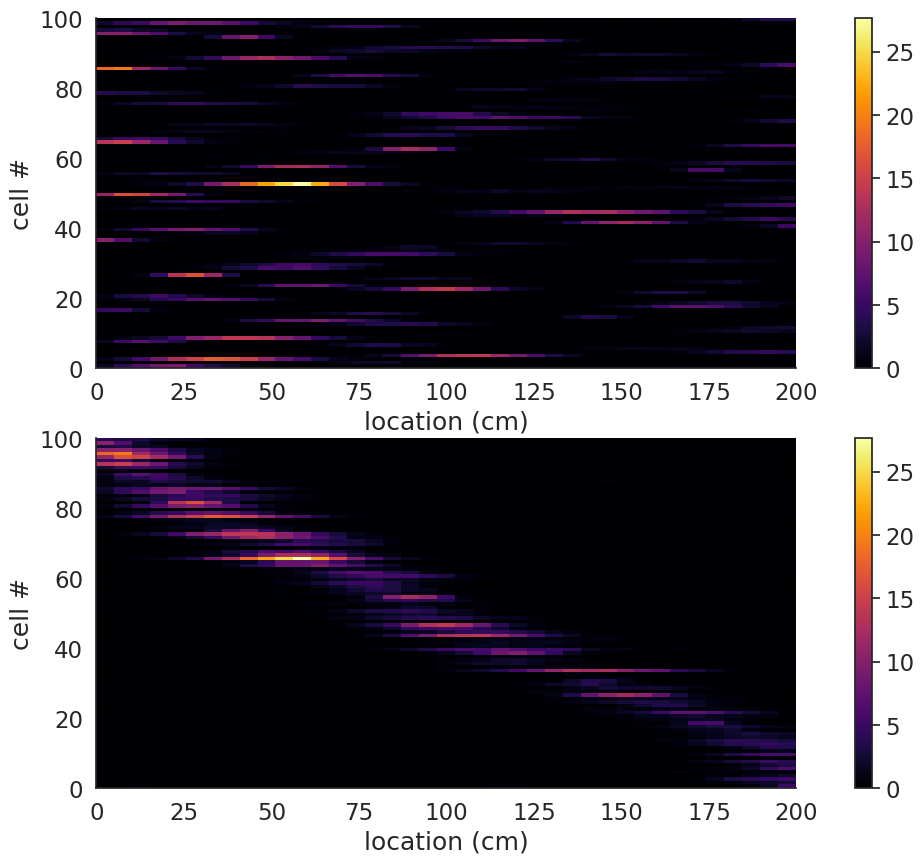

In [10]:
plot_maps(t, x, spikes)

#A

  Larger bins (coarser binning) decrease the spatial resolution of the firing rate maps. Each bin covers a wider range of space, which means fewer bins cover the same track length.

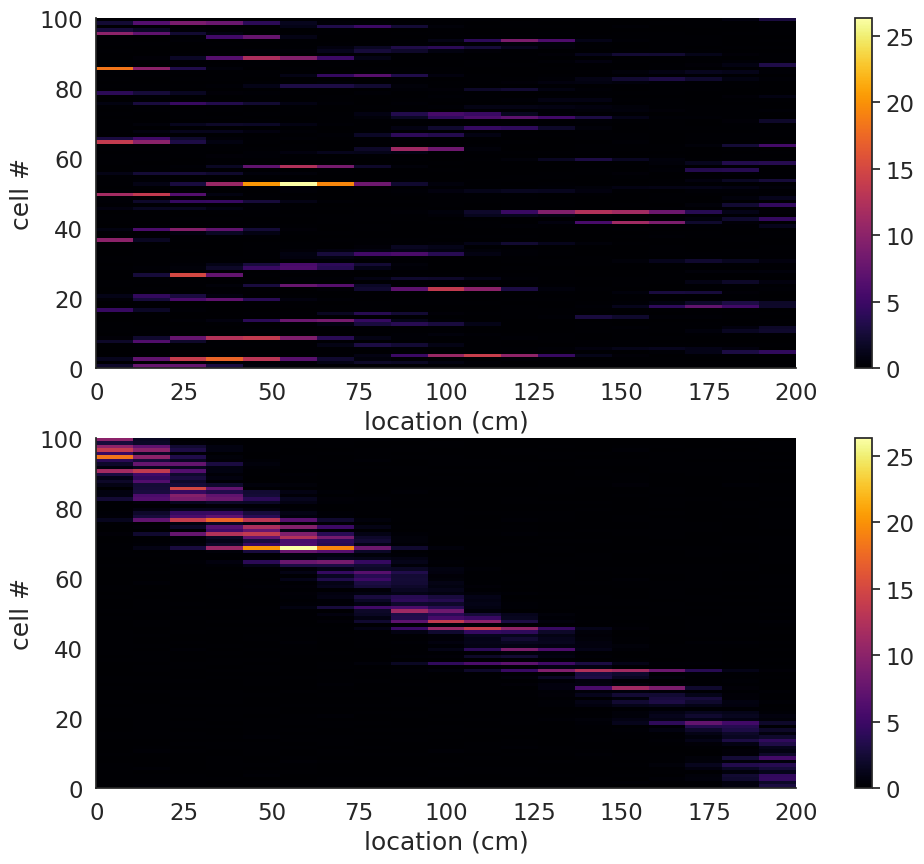

In [11]:
plot_maps(t, x, spikes, space_bins=(np.arange(0., 200., 10.)))

#B

The variable controlling the noise is the 'noise_firing_rate'. As higher the noise level as higher the base line firing rate of the cells, so the firing rate maps become less distinct. With higher noise it is advantageous to use larger bin sizes to 'smooth' the fluctuations over a larger time interval.

In [12]:
track_length = 200. # the length of our linear track (eg in centimeter)
average_firing_rate = 5 # the peak firing rate, averaged across the population
n_cells = 100 # how many cells we are recording
bins = np.arange(0., 200.)
n_runs=20
av_running_speed=10
fps=30
true_firing_rate_maps, pf_centers = get_true_firing_rate(bins, n_cells)
t, x = simulate_mouse_trajectory(bins, n_runs, av_running_speed, fps)
spikes = simulate_spiking(t, x, sampling_rate=10000., noise_firing_rate = 1)

100%|██████████| 100/100 [01:35<00:00,  1.05it/s]


spacial resolution = 5

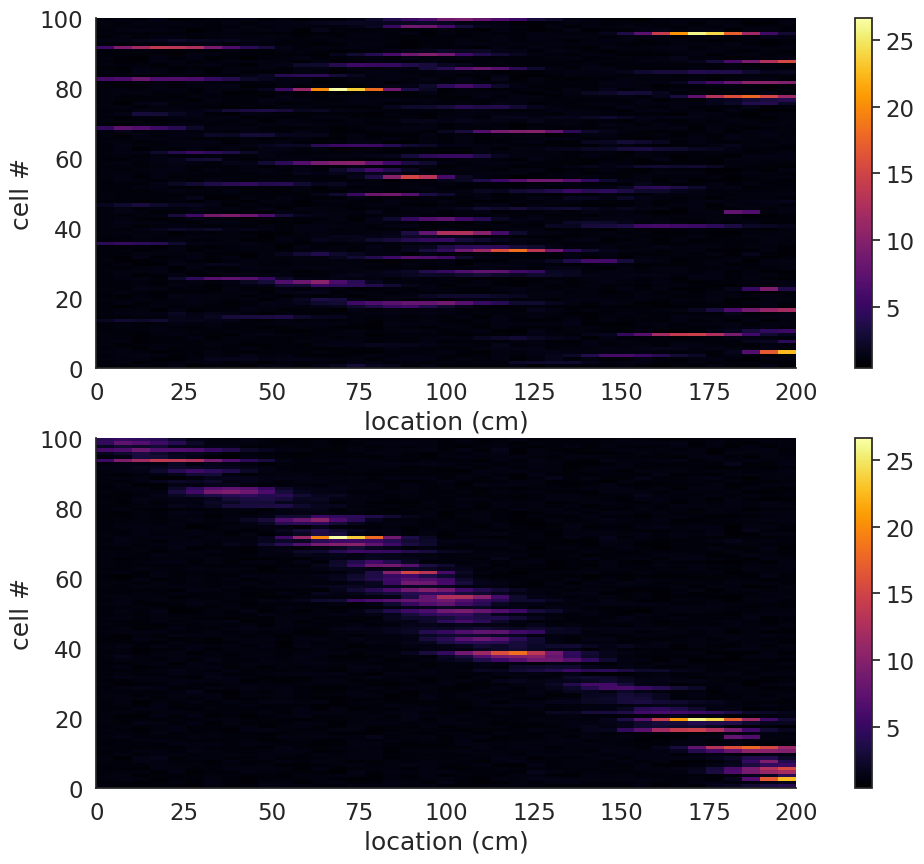

In [13]:
plot_maps(t, x, spikes, space_bins=(np.arange(0., 200., 5.)))

spacial resolution = 15

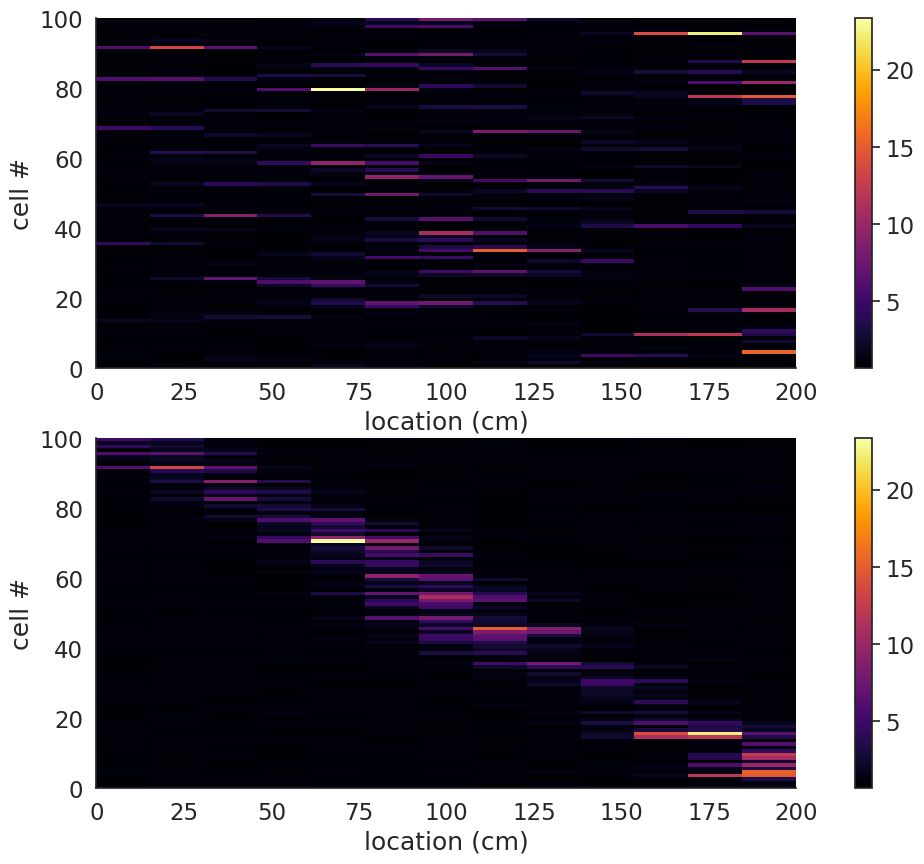

In [14]:
plot_maps(t, x, spikes, space_bins=(np.arange(0., 200., 15.)))

#C

For lower noise levels this works greate. At high noise levels the data becomes very fade.

In [15]:
from scipy.stats import gaussian_kde


def plot_smooth_maps(t, x, spikes, space_bins=np.arange(0., 200., 1.), bandwidth=0.5):
    space_points = np.linspace(space_bins.min(), space_bins.max(), 1000)
    firing_rate_maps = np.zeros((len(spikes), len(space_points)))
    # Iterate through each neuron's spike data. Needed because spikes is inhomogenious.
    for i, spike_times in enumerate(spikes):
        if len(spike_times) > 0:
            spike_positions = np.interp(spike_times, t, x)
            kde = gaussian_kde(spike_positions.T, bw_method=bandwidth)
            firing_rate_maps[i] = kde(space_points) * len(spike_positions) / (t[-1] - t[0])
        else:
            firing_rate_maps[i] = np.zeros(len(space_points))

    # Calculate occupancy using KDE for smoothing
    if len(x) > 1:
        occupancy_kde = gaussian_kde(x, bw_method=bandwidth)
        occupancy = occupancy_kde(space_points) * len(x) / (t[-1] - t[0])
        firing_rate_maps /= occupancy[np.newaxis, :]  # Normalize each row by the occupancy

    # Plotting
    peak_locations = firing_rate_maps.argmax(axis=1)
    ix = np.argsort(peak_locations)

    fig, ax = plt.subplots(2, figsize=(15,10))
    im0 = ax[0].imshow(firing_rate_maps, cmap='inferno', extent = [0, 200, 0, n_cells])
    ax[0].set_xlabel('location (cm)')
    ax[0].set_ylabel('cell #')
    fig.colorbar(im0, ax=ax[0], orientation='vertical')
    im1 = ax[1].imshow(firing_rate_maps[ix,:], cmap='inferno', extent = [0, 200, 0, n_cells])
    ax[1].set_xlabel('location (cm)')
    ax[1].set_ylabel('cell #')
    fig.colorbar(im1, ax=ax[1], orientation='vertical')




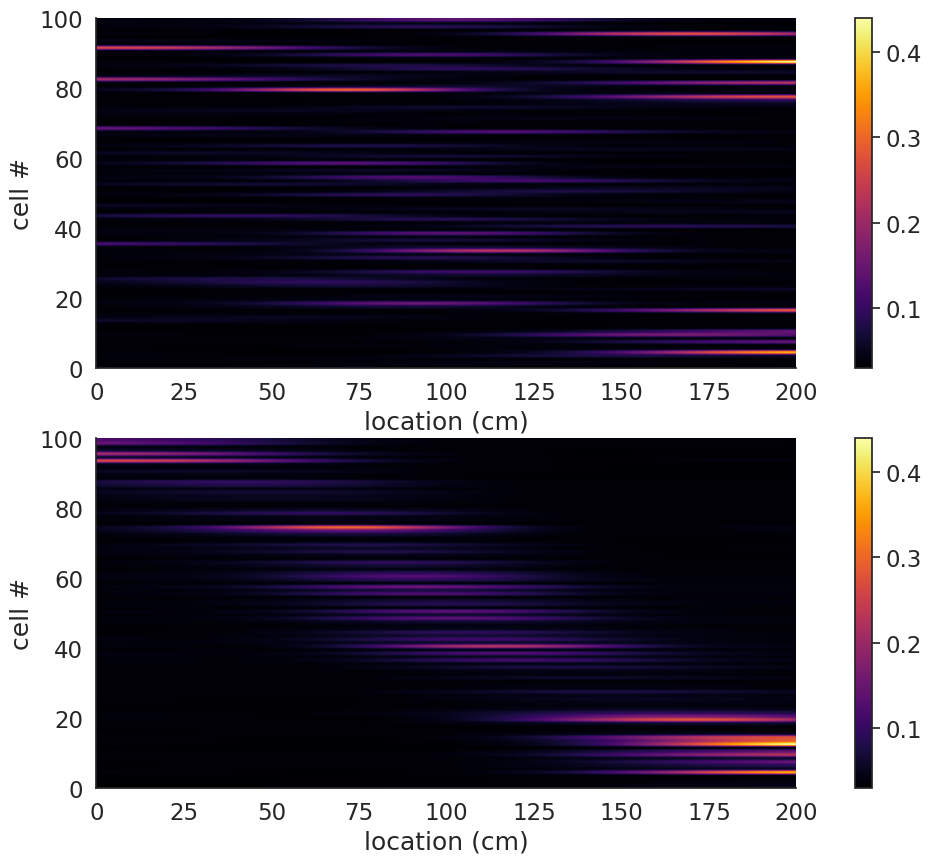

In [16]:
plot_smooth_maps(t, x, spikes)

#D

In [17]:
def calculate_centre_of_mass(spikes, t, x):
    coms = []
    for spike_times in spikes:
        if len(spike_times) > 0:
            spike_positions = np.interp(spike_times, t, x)
            com = np.mean(spike_positions)  # Center of mass as the mean of positions
        else:
            com = np.nan  # No spikes, no center of mass
        coms.append(com)
    return coms
def compare_centers(coms, true_centers):
    # Simple difference between centers
    differences = np.abs(np.array(coms) - np.array(true_centers))
    return differences




Text(0, 0.5, 'difference in centre of mass')

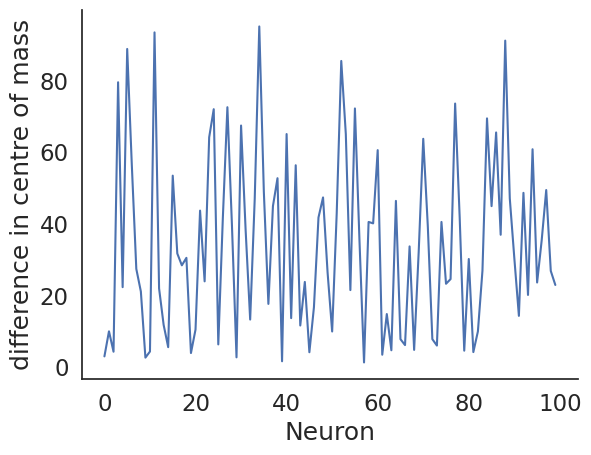

In [18]:
# Calculate the center of mass for spikes
spikes_coms = calculate_centre_of_mass(spikes, t, x)

# Compare computed CoMs with true place field centers
differences = compare_centers(spikes_coms, pf_centers)

plt.plot(differences)
plt.xlabel("Neuron")
plt.ylabel("difference in centre of mass")


## Exercise 2 - mutual information
---
A - Implement the mutual information formula discussed in the lesson, and apply it to the place cell data we simulated.

B - Adapt the simulation so that you can systematically vary 1) Peak firing rate, 2) place cell size 3) baseline noise.
Study how mutual information vary with these parameters. Use both definition of mutual information above, and discuss the differences between them. Make some plots to show how the dependency goes.

#A

In [19]:

def calculate_spatial_information(firing_rate_maps, occupancy, total_time):
    epsilon = 1e-15
    I = np.zeros(firing_rate_maps.shape[0])  # Information for each cell
    p_occ_x = occupancy / total_time  # Normalized occupancy probability
    for i in range(firing_rate_maps.shape[0]):  # Loop over each cell
        lambda_x = firing_rate_maps[i, :]  # Firing rate for cell i in each bin
        lambda_ = np.sum(lambda_x * p_occ_x)  # Average firing rate weighted by occupancy

        if lambda_ > 0:  # Avoid computation for silent cells
            # Mutual information calculation
            term = lambda_x * np.log2((lambda_x + epsilon) / lambda_)
            I[i] = np.sum(term * p_occ_x)  # Sum over all spatial bins

    return I, I / lambda_  # Return I and I_s


def get_fmaps_and_occupancy(t, x, spikes, space_bins=np.arange(0., 200., 5.)):
  spike_positions = [np.interp(s, t, x) for s in spikes]
  spikes_hist= [np.histogram(s, space_bins)[0] for s in spike_positions]

  # put them together into a matrix of floating point numbers (for plotting)
  spikes_hist = np.vstack(spikes_hist).astype(np.float64)

  # we also need an "occupancy histogram" in order to normalize the firing rates maps
  occupancy = np.histogram(x, space_bins)[0] /  fps

  firing_rate_maps = spikes_hist / occupancy
  return firing_rate_maps, occupancy

def plot_information_distribution(spatial_info_per_spike, spatial_info_per_sec, bins=20):
  fig, ax = plt.subplots(2, figsize=(10,15))
  ax[0].hist(spatial_info_per_spike, bins=bins)
  ax[0].set_xlabel('Spatial Information (bits per spike)')
  ax[0].set_ylabel('Count of Cells')
  ax[0].set_title('Distribution of Spatial Information')
  ax[0].grid(True)
  ax[1].hist(spatial_info_per_sec, bins=bins)
  ax[1].set_xlabel('Spatial Information (bits per second)')
  ax[1].set_ylabel('Count of Cells')
  ax[1].grid(True)






(100,) (100,)


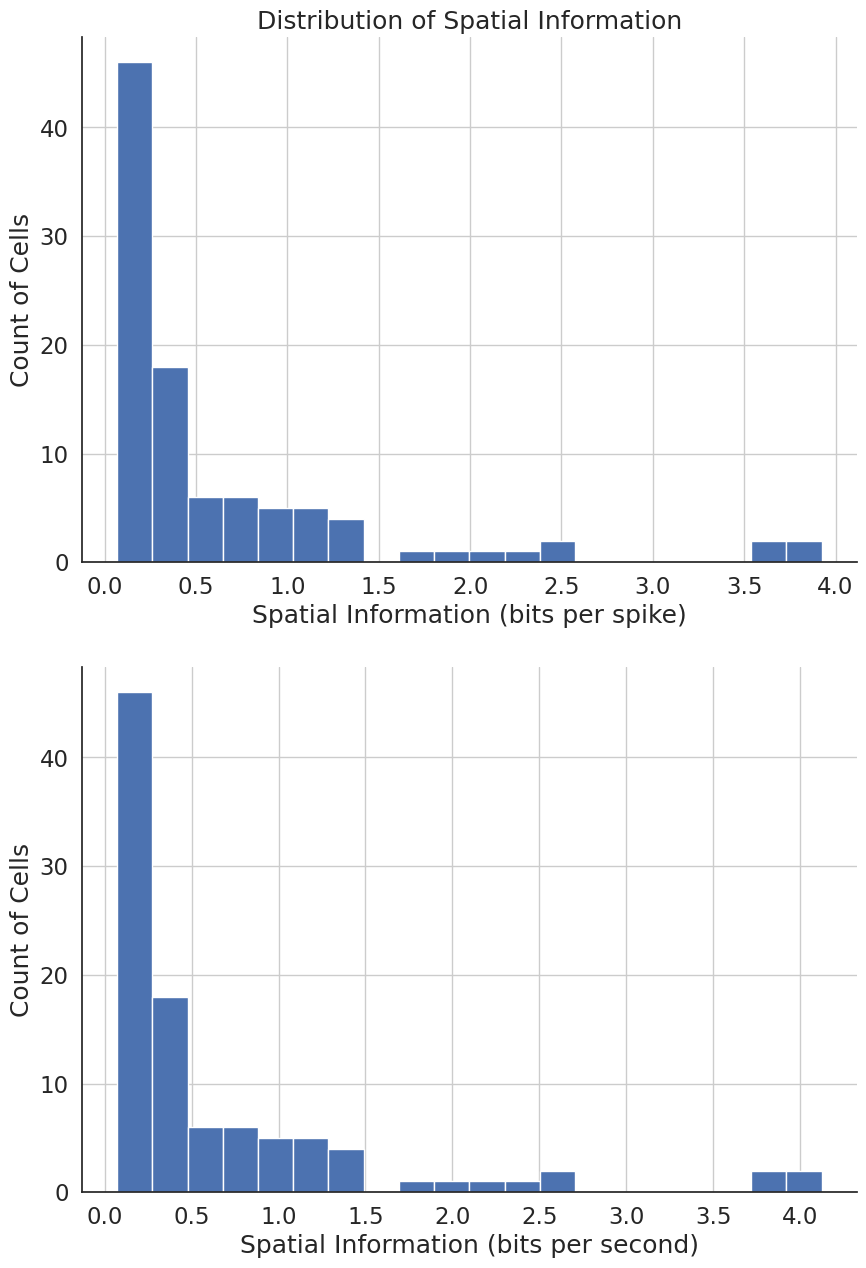

In [20]:

firing_rate_maps, occupancy = get_fmaps_and_occupancy(t, x, spikes, space_bins=np.arange(0., 200., 1.))

total_time = sum(occupancy)

# Spatial information

I, I_s = calculate_spatial_information(firing_rate_maps, occupancy, total_time)
print(np.shape(I), np.shape(I_s))
plot_information_distribution(I_s, I)


#B

The information content increases with a higher firering rate as well as with a larger place cells (more overlap). The noise decreases it slightly.

In [21]:
def var_get_true_firing_rate(bins= np.arange(0., 200.), n_cells=100, peak_firing_rate=5, place_cell_size=10):
    true_firing_rate_maps = np.zeros((n_cells, len(bins)))
    pf_centers = np.random.uniform(low=0, high=max(bins), size=n_cells)   # the centers of the place fields for all cells drawn randomly with a uniform distribution on the track
    pf_size = np.random.gamma(shape=place_cell_size, size=n_cells)  # the size (width) of the place fields, drawn randomly from a gamma distribution
    pf_rate = np.random.exponential(scale=peak_firing_rate, size=n_cells)    # the peak firing rate for each cell, drawn from an exponential distribution

    for i in range(n_cells):
        true_firing_rate_maps[i,:] = pf_rate[i] * np.exp(-((bins-pf_centers[i])**2)/(2*pf_size[i]**2))
    return true_firing_rate_maps, pf_centers



In [22]:
import itertools
peak_firing_rates = [5, 10]
place_cell_sizes = [1, 10 ]
baseline_noises = [0.1, 0.5]

track_length = 200. # the length of our linear track (eg in centimeter)
average_firing_rate = 5 # the peak firing rate, averaged across the population
n_cells = 100 # how many cells we are recording
bins = np.arange(0., 200.)
n_runs=20
av_running_speed=10
fps=30

Is_list = np.zeros((8, 100))
I_list = np.zeros((8, 100))
for i, (peak_f, cell_size, noise) in enumerate(itertools.product(peak_firing_rates, place_cell_sizes, baseline_noises)):

  true_firing_rate_maps, _ = var_get_true_firing_rate(bins, n_cells, peak_firing_rate=peak_f, place_cell_size=cell_size)
  t, x = simulate_mouse_trajectory(bins, n_runs, av_running_speed, fps)
  spikes = simulate_spiking(t, x, sampling_rate=10000., noise_firing_rate=noise)
  firing_rate_maps, occupancy = get_fmaps_and_occupancy(t, x, spikes, space_bins=np.arange(0., 200., 1.))
  I, I_s = calculate_spatial_information(firing_rate_maps, occupancy, total_time)
  I_list[i] = I
  Is_list[i] = I_s



100%|██████████| 100/100 [01:12<00:00,  1.37it/s]


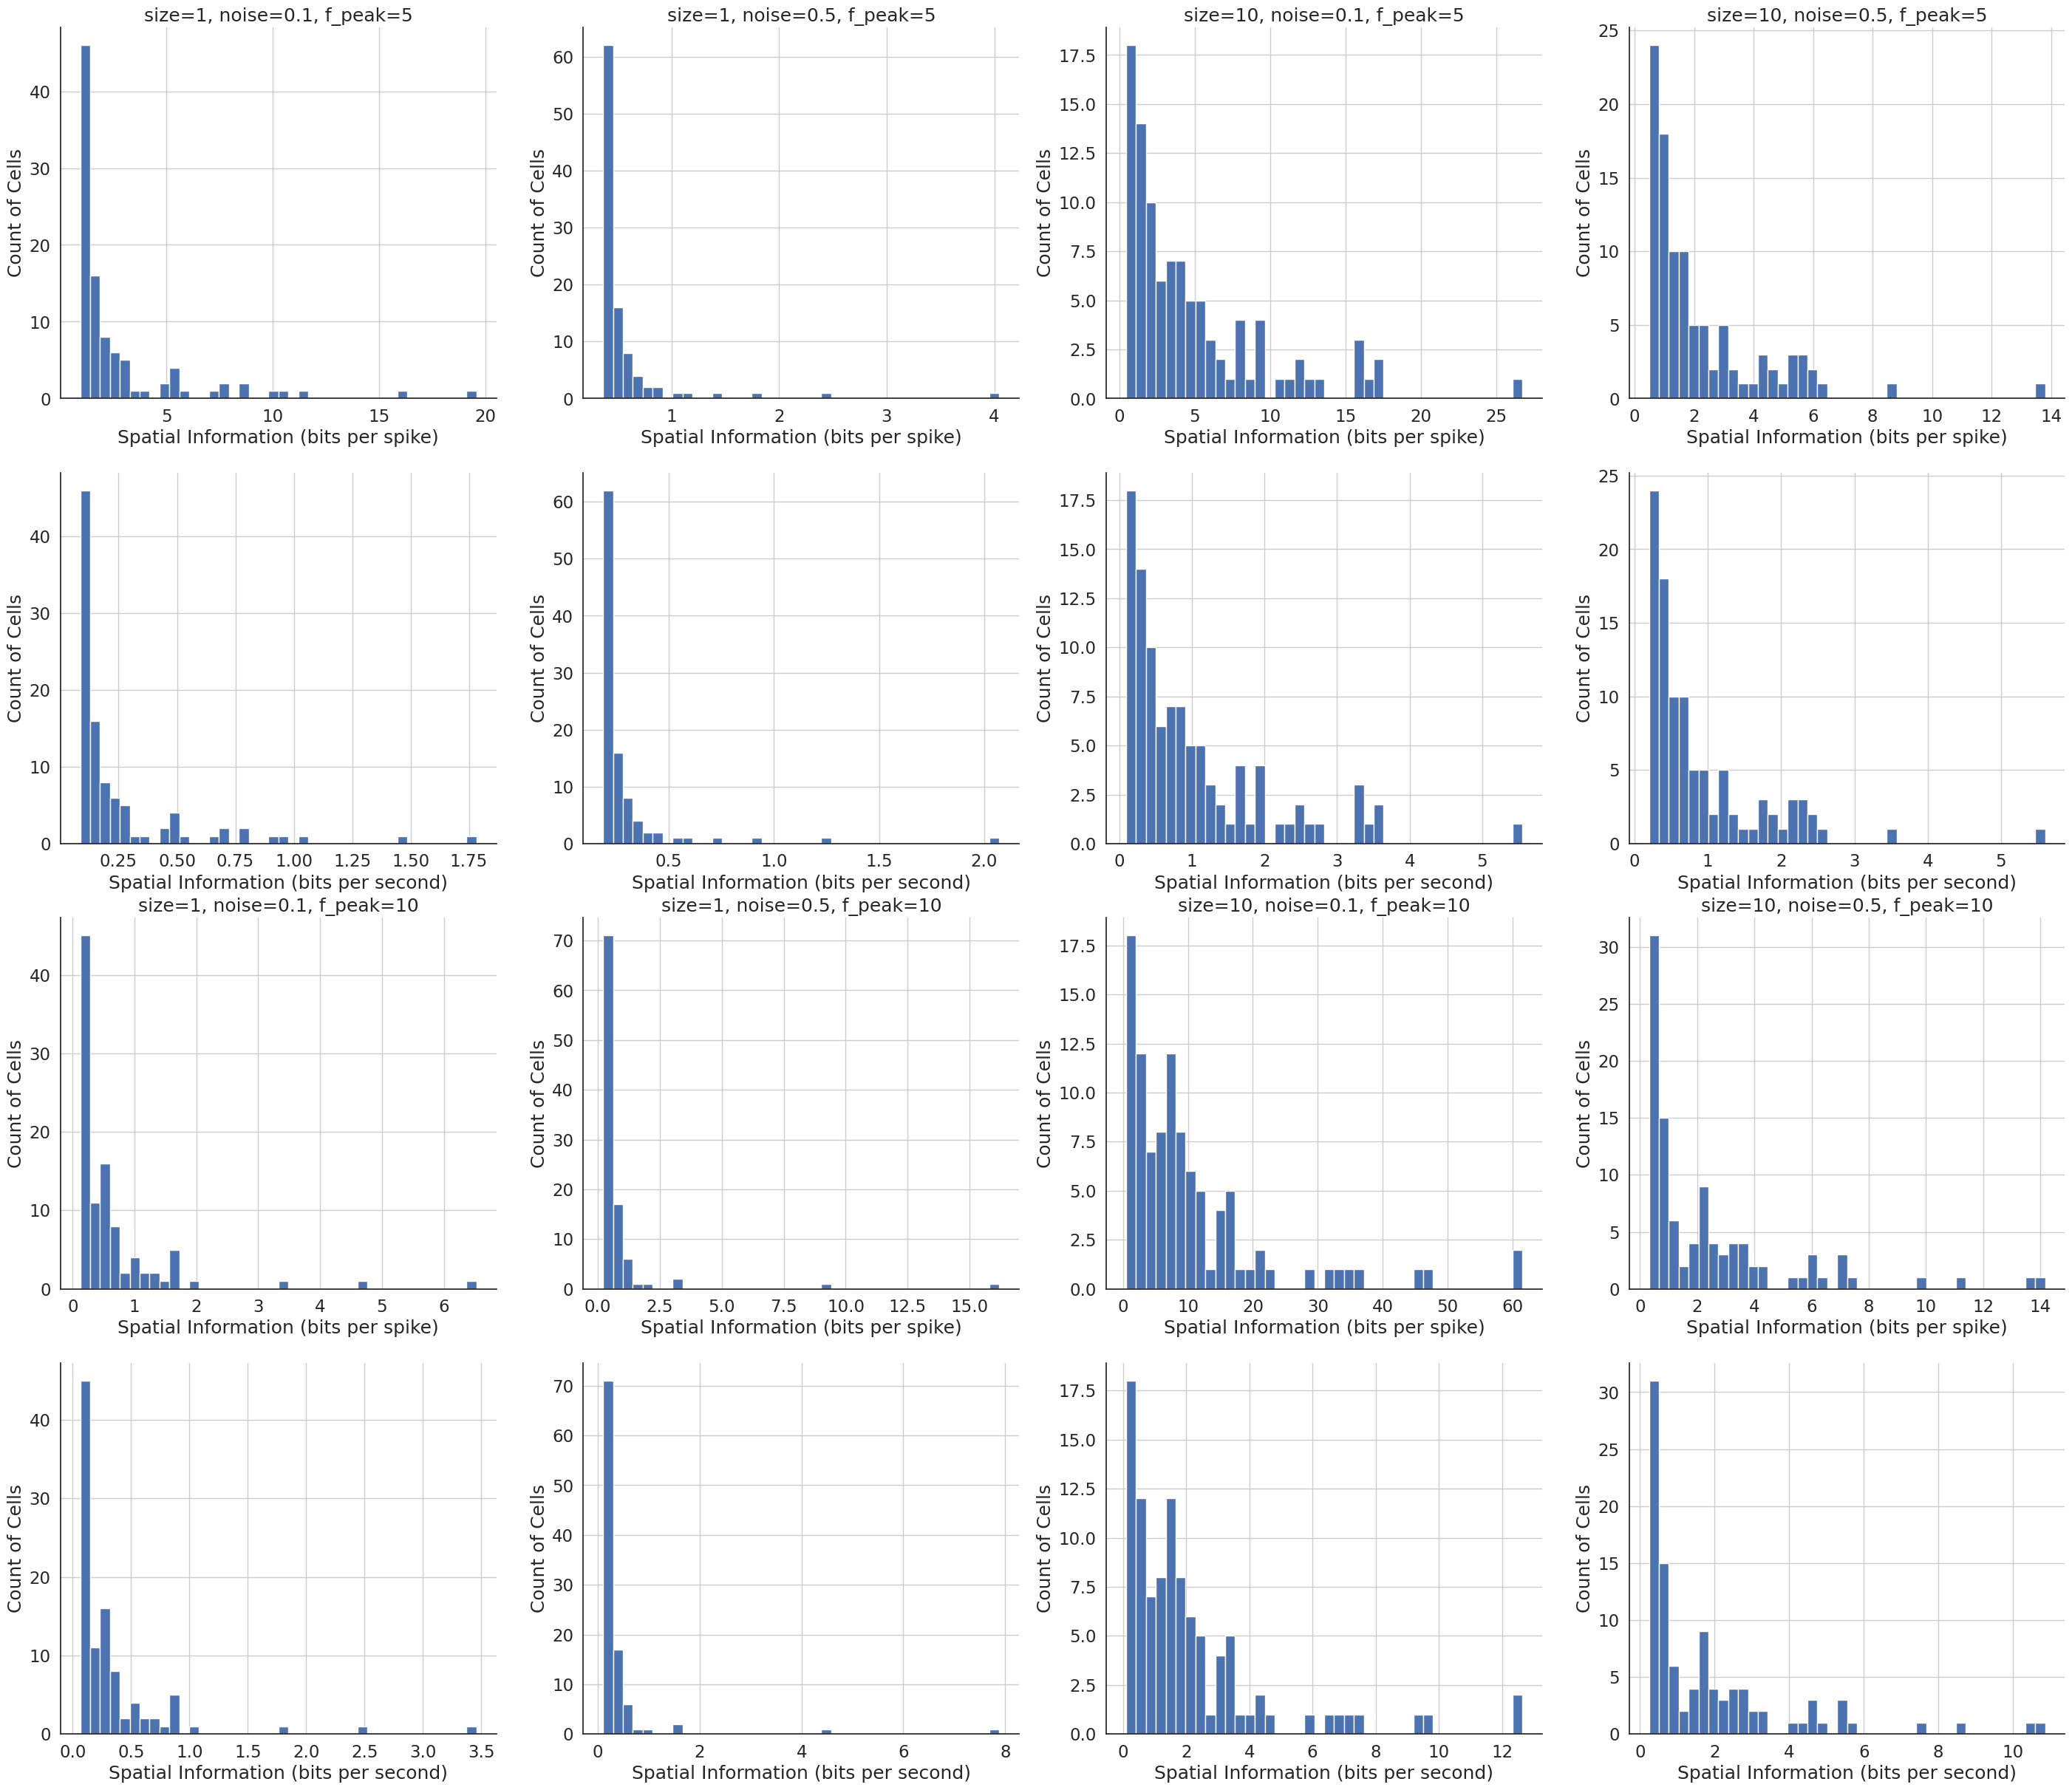

In [23]:
fig, ax = plt.subplots(4, 4, figsize=(35,30))
for i, (peak_f, cell_size, noise) in enumerate(itertools.product(peak_firing_rates, place_cell_sizes, baseline_noises)):
  ax[i//4*2, i%4].hist(Is_list[i], bins=40)
  ax[i//4*2, i%4].set_xlabel('Spatial Information (bits per spike)')
  ax[i//4*2, i%4].set_ylabel('Count of Cells')
  ax[i//4*2, i%4].set_title('size={cell}, noise={noise}, f_peak={peak}'.format(cell=cell_size, noise=noise, peak=peak_f))
  ax[i//4*2, i%4].grid(True)
  ax[i//4*2+1, i%4].hist(I_list[i], bins=40)
  ax[i//4*2+1, i%4].set_xlabel('Spatial Information (bits per second)')
  ax[i//4*2+1, i%4].set_ylabel('Count of Cells')
  ax[i//4*2+1, i%4].grid(True)

## Exercise 3 - working with real data
---
Load the data from `linear_track_data.pickle`. It contains neural recordings from a mouse running on a linear track.
- `x` contains the position of the animal
- `t` contains the corresponding times, in seconds
- `spikes` contains a list of lists. Each list contains the timestamps of the spikes emitted by a neuron.

A - Visualiaze the position a s a function of time. Plot the spike of a selected cell in space.

B - Calculate the firing rate maps for all the cells, and plot them sorted by increasing peak positon.

C - Calculate the spatial information for each cell, and plot the distribution. Plot the firing rate maps of the 5 cells with lower spatial information, and the firing rate maps of the 5 cells with higher spatial information. Comment on the differences.

In [24]:
# Download lesson data
download_data('https://surfdrive.surf.nl/files/index.php/s/FeDX3LfbJ4pC7T6')
#import data
with open('data/linear_track_data.pickle', 'rb') as handle:
    data = pickle.load(handle)

x = data['x']
t= data['t']
spikes = data['spikes']


(1588,)


Text(0.5, 0, 'Time')

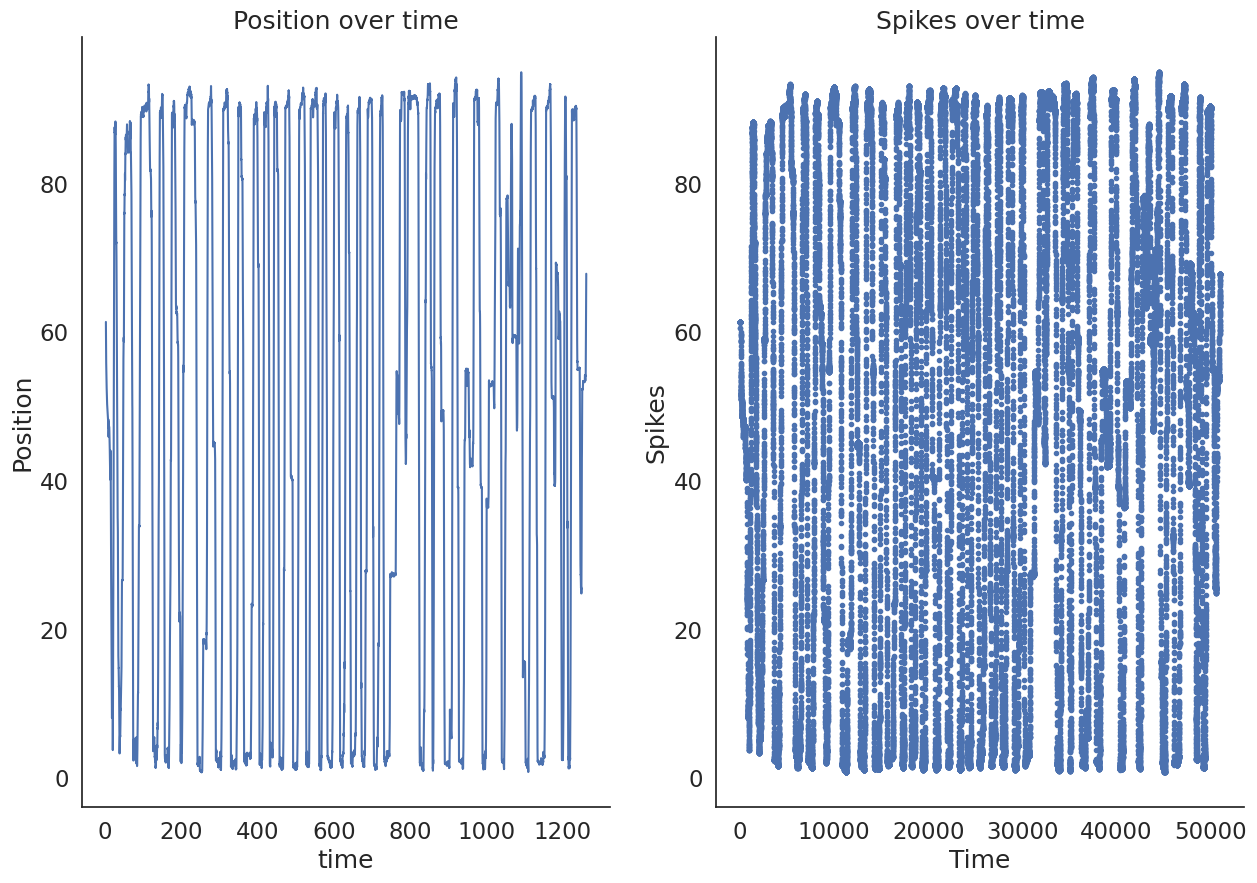

In [25]:
spike_positions = [np.interp(s, t, x) for s in spikes]
print(np.shape(spike_positions[2]))
fig, ax = plt.subplots(1,2, figsize = (15,10))
ax[0].set_title("Position over time")
ax[0].plot(t, x)
ax[0].set_ylabel("Position")
ax[0].set_xlabel("time")
ax[1].set_title("Spikes over time")
ax[1].plot(spike_positions[0], '.')
ax[1].set_ylabel("Spikes")
ax[1].set_xlabel("Time")

#B

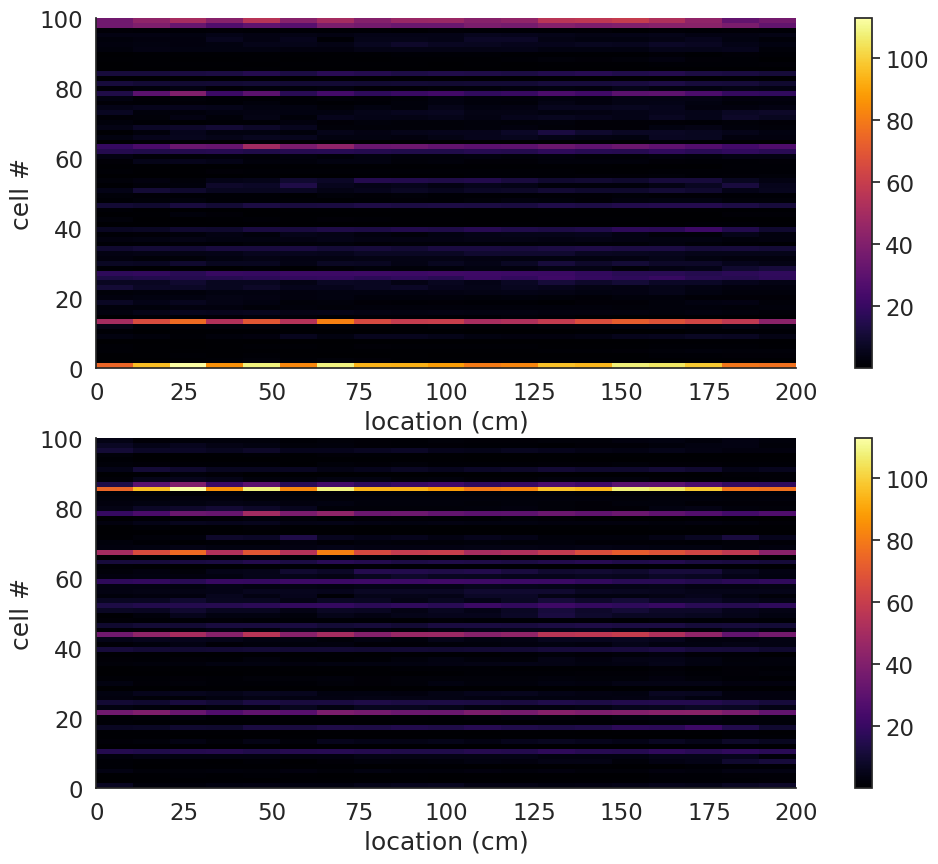

In [26]:
plot_maps(t,x,spikes, space_bins=np.arange(0., 100., 5.))

#C

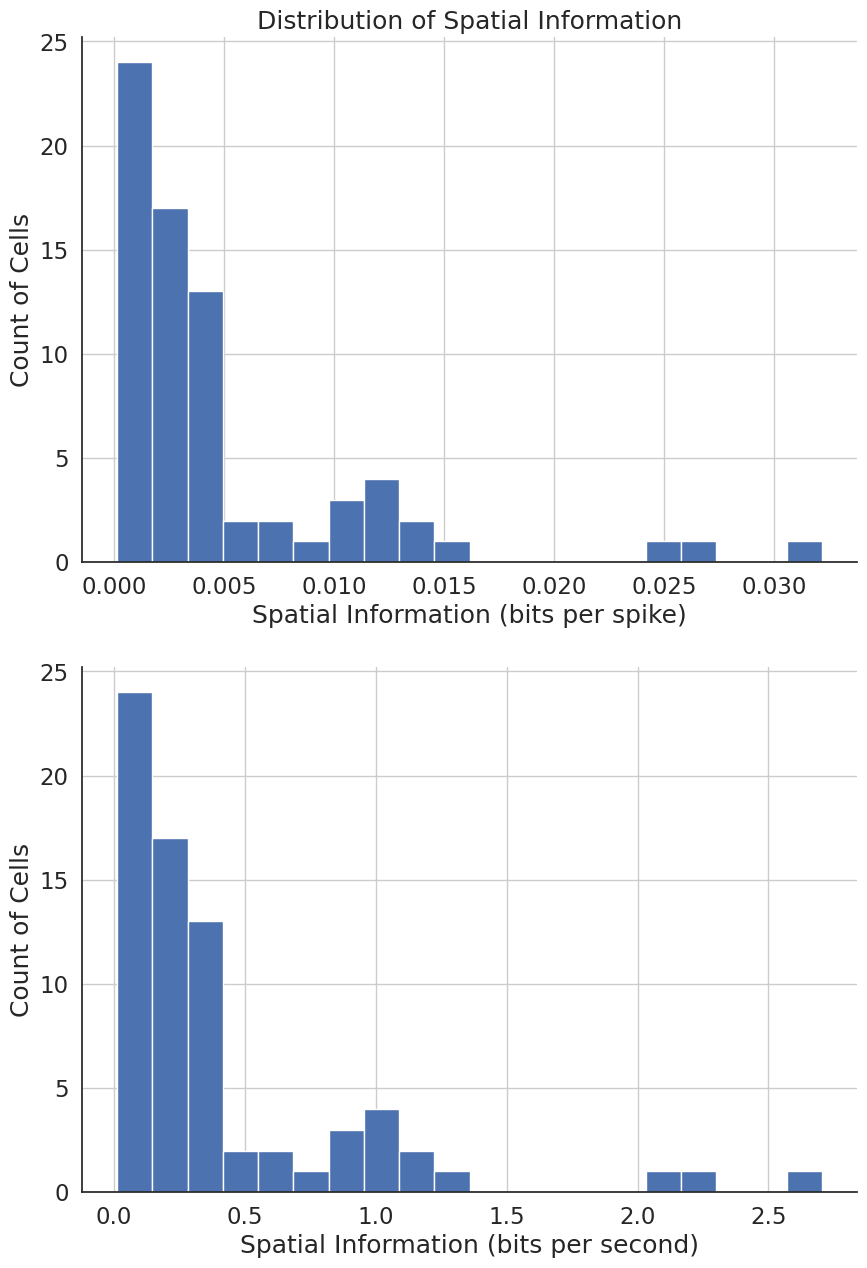

In [27]:
firing_rate_maps, occupancy = get_fmaps_and_occupancy(t, x, spikes, space_bins=np.arange(0., 100., 5.))
I, I_s = calculate_spatial_information(firing_rate_maps, occupancy, total_time=t[-1])
plot_information_distribution(I_s, I)


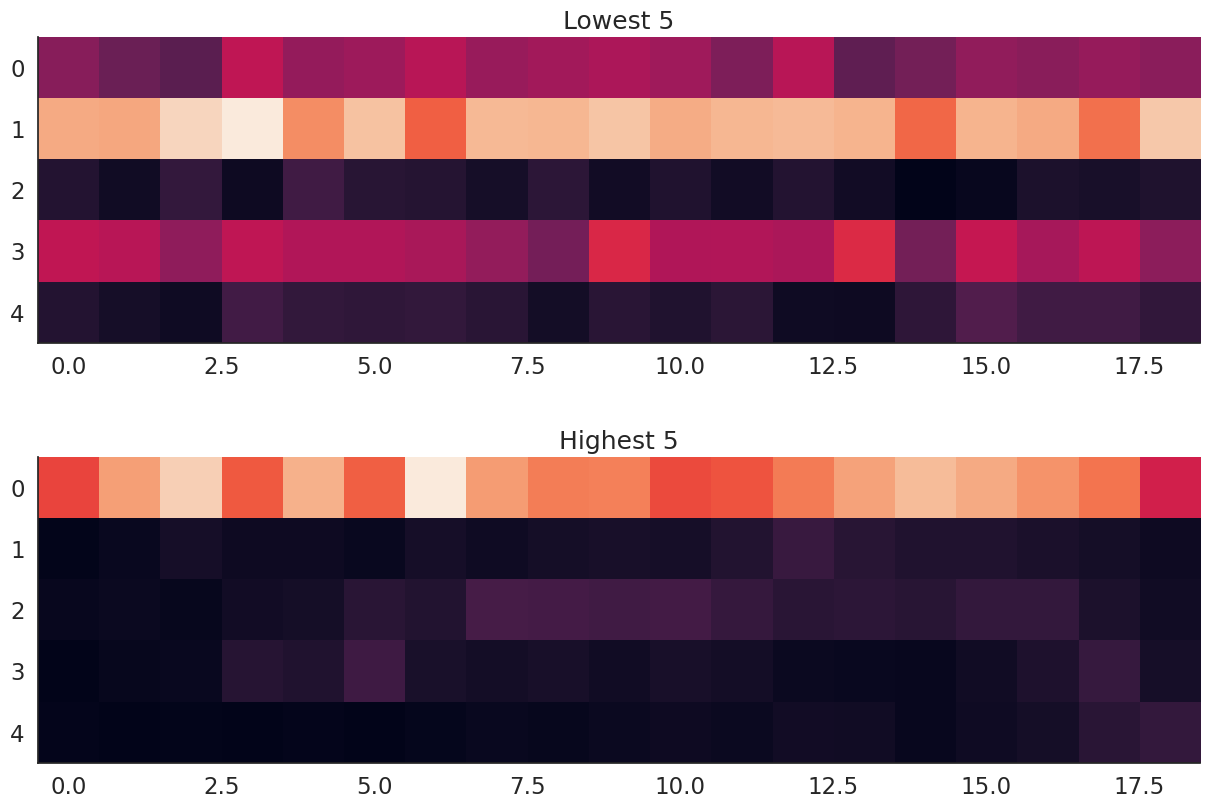

In [28]:
I_sort = np.argsort(I)
Is_sort = np.argsort(I_s)
fig, ax = plt.subplots(2, figsize=(15,10))
ax[0].set_title("Lowest 5")
ax[0].imshow(firing_rate_maps[I_sort[:5]])
ax[1].set_title("Highest 5")
ax[1].imshow(firing_rate_maps[I_sort[-5:]])